In [13]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib
import math
import os 
import torch.nn.functional as F

import importlib
import data_analysis
importlib.reload(data_analysis)

import autoencoder
importlib.reload(autoencoder)

import utils
importlib.reload(utils)

%matplotlib inline
matplotlib.pyplot.rc('text', usetex=True)
fontsize = 18


print(f'Working in {os.getcwd()}')

Working in /projects/IceDynamics/Stage_M2/code


In [2]:
from utils import get_freer_gpu

device = get_freer_gpu() if torch.cuda.is_available() else "cpu"

Selected GPU 0 with 46953 MB free memory 


In [3]:
from data_analysis import Simulation
from data_analysis import compatible_path
current_directory = compatible_path('../')

simulation = Simulation(current_directory, normalize = True)
time, x, z, u, w, T, umean, wmean, Tmean = map(lambda x: torch.tensor(x, dtype=torch.float64).to(device), simulation.import_data())
simulation.image_rgb()

h, l = np.shape(x)
m = len(time)
print(m)
N = h*l*3

print(simulation.Umax, simulation.Wmax, simulation.Tmax)

6249
3053.072463137826 2543.305241913497 0.07238184027748469


# Dataset

In [4]:
from autoencoder import SimuDataset

batch_size = 4

dataset = SimuDataset(simulation, device,  rgb = True, training_ratio = 0.9)
first = dataset[0]
dataloader = DataLoader(dataset = dataset, batch_size = batch_size, shuffle = True)

dataiter = iter(dataloader)
data, t = next(dataiter)
print(torch.min(data), torch.max(data), data.shape)

tensor(-0.7436, device='cuda:0', dtype=torch.float64) tensor(0.7258, device='cuda:0', dtype=torch.float64) torch.Size([4, 3, 81, 51])


# Model

In [5]:
from autoencoder import ConvolutionalAutoencoder
lr = 1e-4
weight_decay = 0

size1 = (40, 25)
size2 = (20, 12)
size3 = (10, 6)
size4 = (5, 3)

sizes = [size1, size2, size3, size4]

model = ConvolutionalAutoencoder(device = device, sizes = sizes)
model.to(device) 
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)

# Training

In [14]:
num_epoch = 100
output = []
info = []
for epoch in range(num_epoch):
    for map, t in dataloader:
        map = map.float().to(device)
        reconstructed = model(map)
        loss = criterion(reconstructed, map)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch+1}, Loss:{loss.item() : .4f}")
    info.append((epoch, loss.item()))
    output.append((epoch, map, reconstructed))

Epoch: 1, Loss: 0.0141
Epoch: 2, Loss: 0.0095
Epoch: 3, Loss: 0.0122
Epoch: 4, Loss: 0.0059
Epoch: 5, Loss: 0.0057
Epoch: 6, Loss: 0.0040
Epoch: 7, Loss: 0.0062
Epoch: 8, Loss: 0.0055
Epoch: 9, Loss: 0.0045
Epoch: 10, Loss: 0.0038
Epoch: 11, Loss: 0.0037
Epoch: 12, Loss: 0.0027
Epoch: 13, Loss: 0.0040
Epoch: 14, Loss: 0.0040
Epoch: 15, Loss: 0.0074
Epoch: 16, Loss: 0.0043
Epoch: 17, Loss: 0.0045
Epoch: 18, Loss: 0.0023
Epoch: 19, Loss: 0.0039
Epoch: 20, Loss: 0.0038
Epoch: 21, Loss: 0.0041
Epoch: 22, Loss: 0.0024
Epoch: 23, Loss: 0.0031
Epoch: 24, Loss: 0.0035
Epoch: 25, Loss: 0.0023
Epoch: 26, Loss: 0.0024
Epoch: 27, Loss: 0.0027
Epoch: 28, Loss: 0.0022
Epoch: 29, Loss: 0.0036
Epoch: 30, Loss: 0.0040
Epoch: 31, Loss: 0.0020
Epoch: 32, Loss: 0.0028
Epoch: 33, Loss: 0.0033
Epoch: 34, Loss: 0.0031
Epoch: 35, Loss: 0.0026
Epoch: 36, Loss: 0.0020
Epoch: 37, Loss: 0.0020
Epoch: 38, Loss: 0.0023
Epoch: 39, Loss: 0.0020
Epoch: 40, Loss: 0.0021
Epoch: 41, Loss: 0.0032
Epoch: 42, Loss: 0.0034
E

In [ ]:
fig, ax1 = plt.subplots(figsize = (16, 5))


# ax1.scatter(time.cpu(), uz, s = 10, c = 'orange', label = r'ground truth $u_z$')
ax1.scatter(range(len(info)), [info[i][1] for i in range(len(info))], s = 20, c = 'cadetblue')

ax1.set_ylabel(r'$loss$', fontsize= fontsize)
ax1.set_xlabel(r'$epoch$', fontsize = fontsize)
ax1.legend(fontsize = fontsize, loc = 'upper left')

fig.tight_layout()

In [17]:
from utils import info_text
directory = f'{current_directory}/results/autoencoder/cnn/'
torch.save(model.state_dict(), directory + f'model_bs{batch_size}_v2.pt')
info_text(directory, batch_size, sizes, info, version = 2, num_epoch = num_epoch, lr = lr, weight_decay = weight_decay)

# Analysis

In [22]:
batch_size = 4
K = 500
directory = f'{current_directory}/results/autoencoder/cnn/'
title = f'model_bs{batch_size}_K{K}_info.txt'

from utils import get_variables_from_info_text

variables, sizes = get_variables_from_info_text(directory, title)

K: 500
batch_size: 4
size1: (40, 25)
size2: (20, 12)
size3: (10, 6)
size4: (5, 3)
num_epoch: 100
lr: 0.0001
weight_decay: 0
n_channels: 64
epoch_1: 0.01566585712134838
epoch_2: 0.009679585695266724
epoch_3: 0.013028531335294247
epoch_4: 0.007580099627375603
epoch_5: 0.006240535527467728
epoch_6: 0.006376691162586212
epoch_7: 0.004811844788491726
epoch_8: 0.005753685254603624
epoch_9: 0.003718069288879633
epoch_10: 0.0037540215998888016
epoch_11: 0.00409020995721221
epoch_12: 0.005272668786346912
epoch_13: 0.004352174233645201
epoch_14: 0.0028474300634115934
epoch_15: 0.004681907128542662
epoch_16: 0.0038190814666450024
epoch_17: 0.00623294385150075
epoch_18: 0.003838692093268037
epoch_19: 0.0032910178415477276
epoch_20: 0.004928893409669399
epoch_21: 0.004201200325042009
epoch_22: 0.004094134550541639
epoch_23: 0.002329607494175434
epoch_24: 0.004240899346768856
epoch_25: 0.003231863956898451
epoch_26: 0.0030089968349784613
epoch_27: 0.0030688769184052944
epoch_28: 0.003188807284459471

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


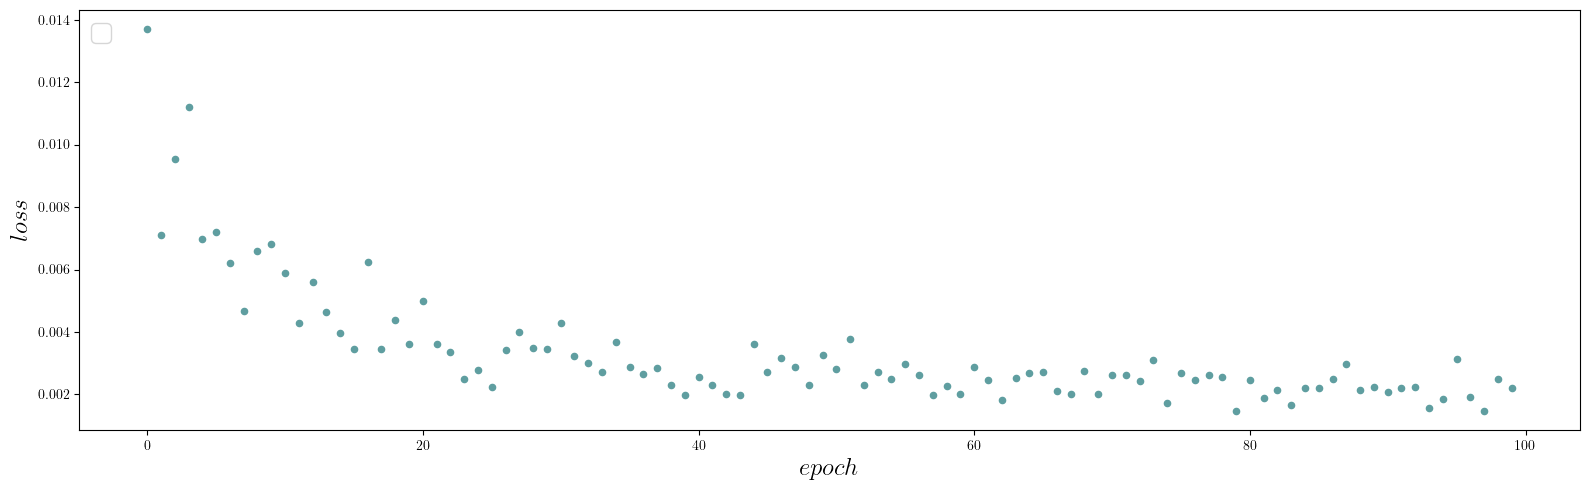

In [5]:
from utils import losses_from_info
epochs, losses = losses_from_info(variables)    

fig, ax1 = plt.subplots(figsize = (16, 5))
# def moving_average(data, window_size):
#     cumsum = np.cumsum(data)
#     return (cumsum[window_size:] - cumsum[:-window_size]) / window_size

# window_size = 2  
# smoothed_losses = moving_average(losses, window_size)

ax1.scatter(range(len(epochs)), losses, s = 20, c = 'cadetblue')
# ax1.plot(range(window_size, len(epochs)), smoothed_losses, c = 'orange')

ax1.set_ylabel(r'$loss$', fontsize= fontsize)
ax1.set_xlabel(r'$epoch$', fontsize = fontsize)
ax1.legend(fontsize = fontsize, loc = 'upper left')

fig.tight_layout()

In [23]:
x.shape

torch.Size([6249, 3, 81, 51])

In [23]:
from autoencoder import ConvolutionalAutoencoder
X = simulation.X_rgb
x = np.swapaxes(torch.from_numpy(X), 0, 1).cpu()
x = x.float()

print(x.shape)
print(K)

def apply_autoencoder(K):
    autoencoder = ConvolutionalAutoencoder(device, sizes, K = K)

    autoencoder.load_state_dict(torch.load(f'{current_directory}/results/autoencoder/cnn/model_bs{batch_size}_K{K}.pt'))
    autoencoder.eval()  # Set the model to evaluation mode


    with torch.no_grad():
        encoded_data = autoencoder.linear_encoder(torch.reshape(autoencoder.encoder(x.to(device)), (m, -1)))

    with torch.no_grad():
        decoded_data = autoencoder.decoder(torch.reshape(autoencoder.linear_decoder(encoded_data), (m, autoencoder.n_channels, sizes[-1][0], sizes[-1][1])))
    return decoded_data

decoded_data = apply_autoencoder(K)

torch.Size([6249, 3, 81, 51])
500


In [11]:
np.shape(X)

(3, 6249, 81, 51)

normalized
normalized
normalized
normalized
normalized
normalized
[0.35803763580717934, 0.3188521908898931, 0.29157923737426167, 0.27832527955449693, 0.2819557758959028, 0.27653563270994813] [0.44048410217433775, 0.368705480098064, 0.3305055763938664, 0.3102297462318205, 0.3132218405449773, 0.3098509795725784] [0.35027933318393917, 0.3143335545364366, 0.2880922789304308, 0.27549515756432, 0.2791876777612271, 0.27357136935709075]


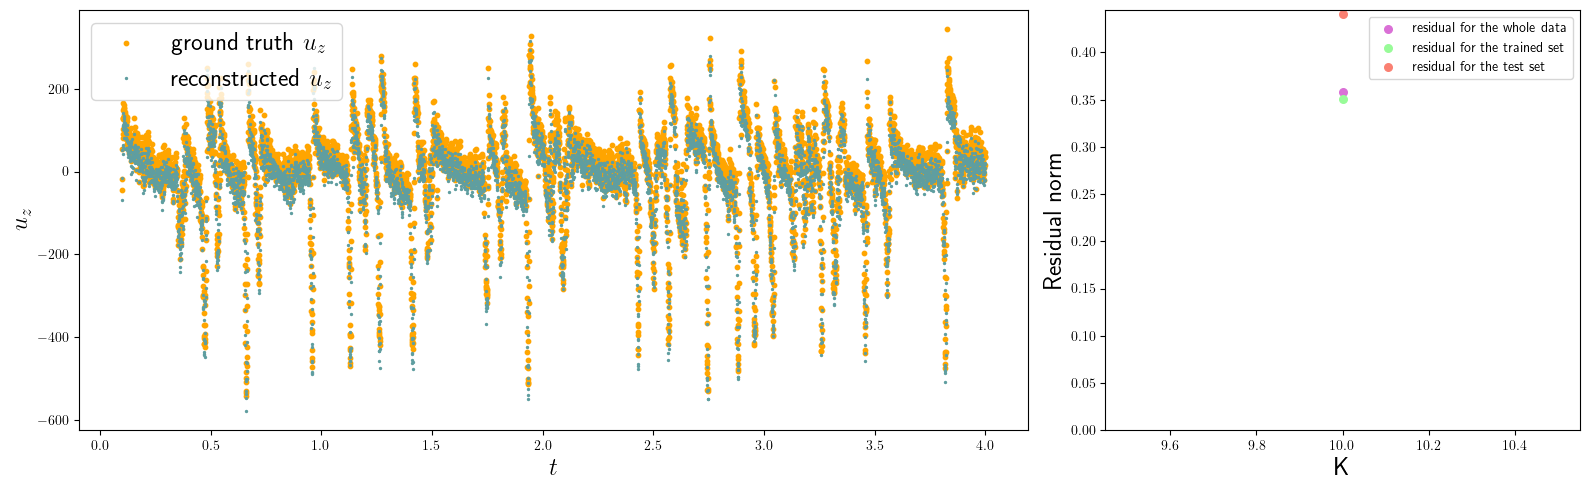

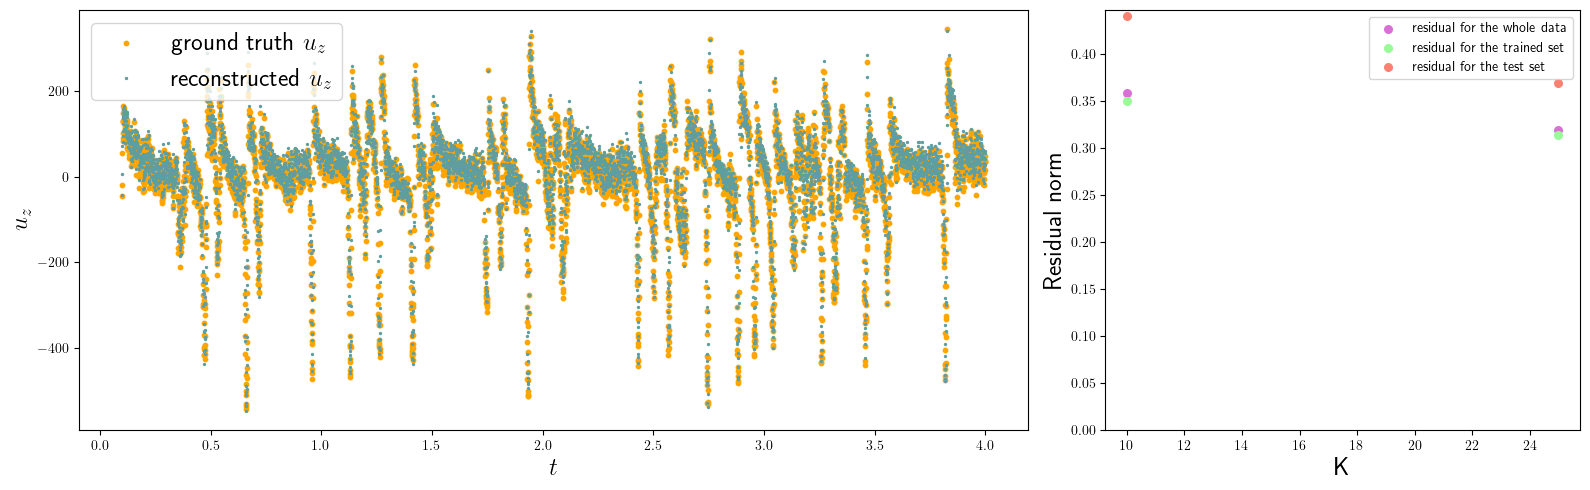

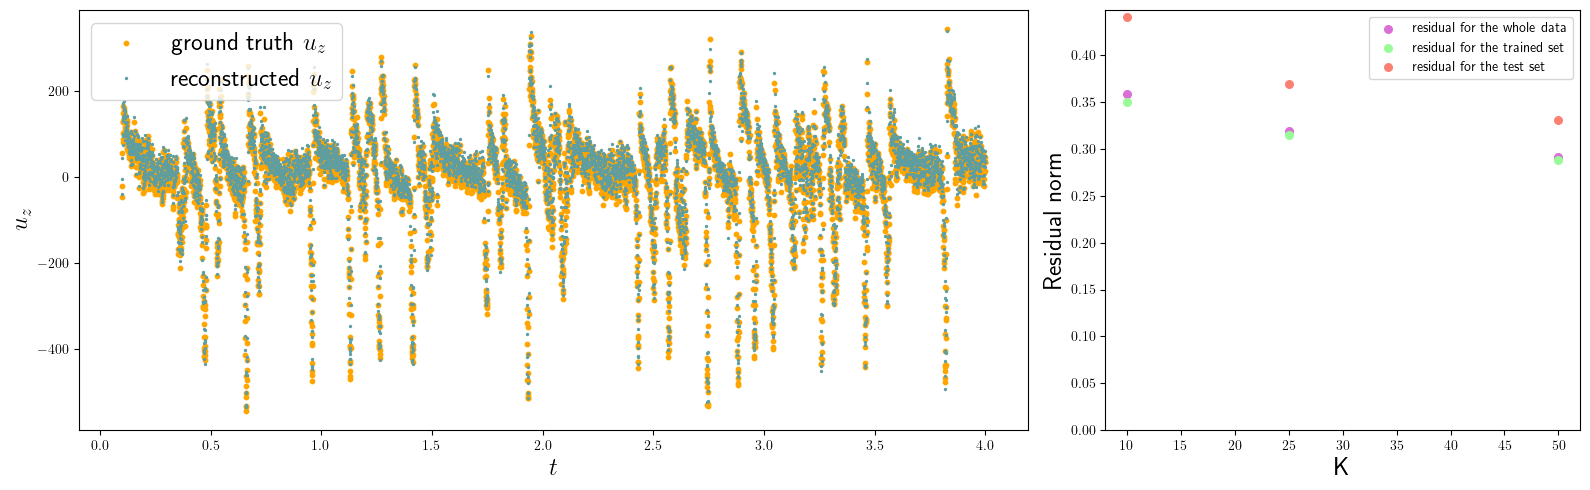

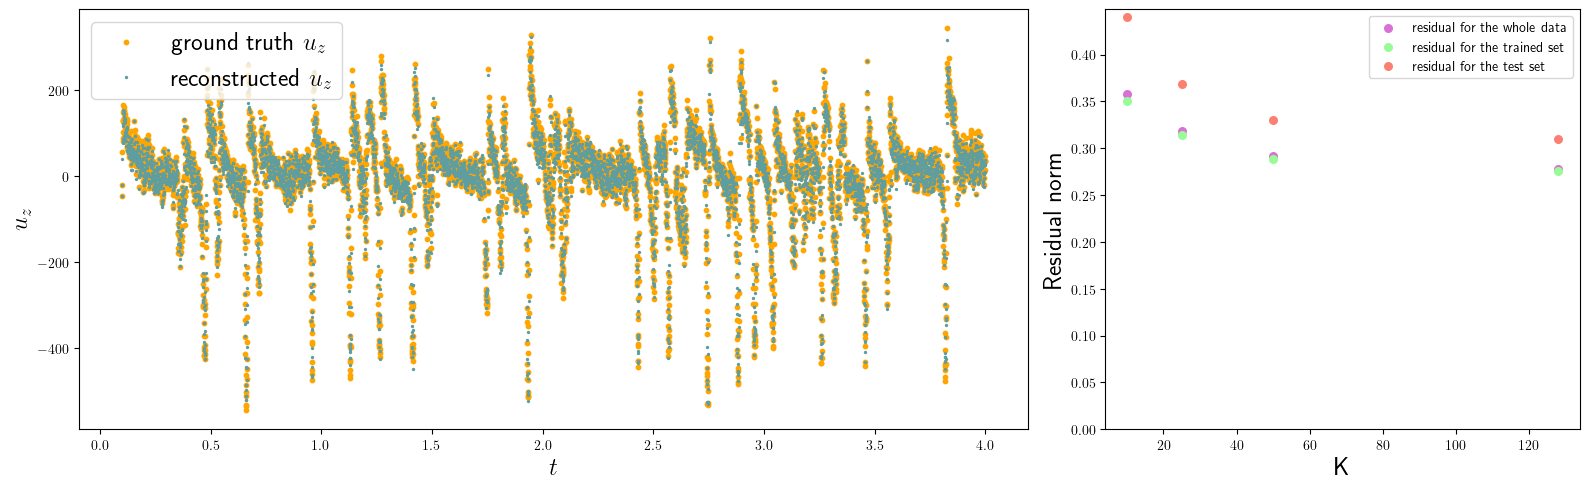

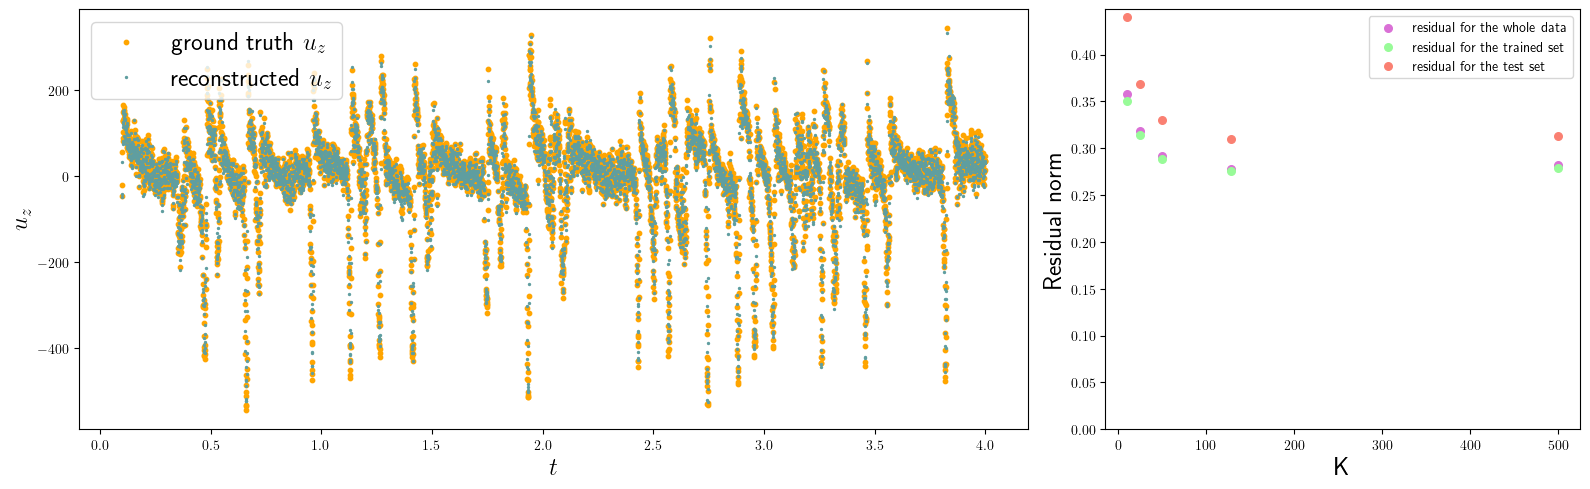

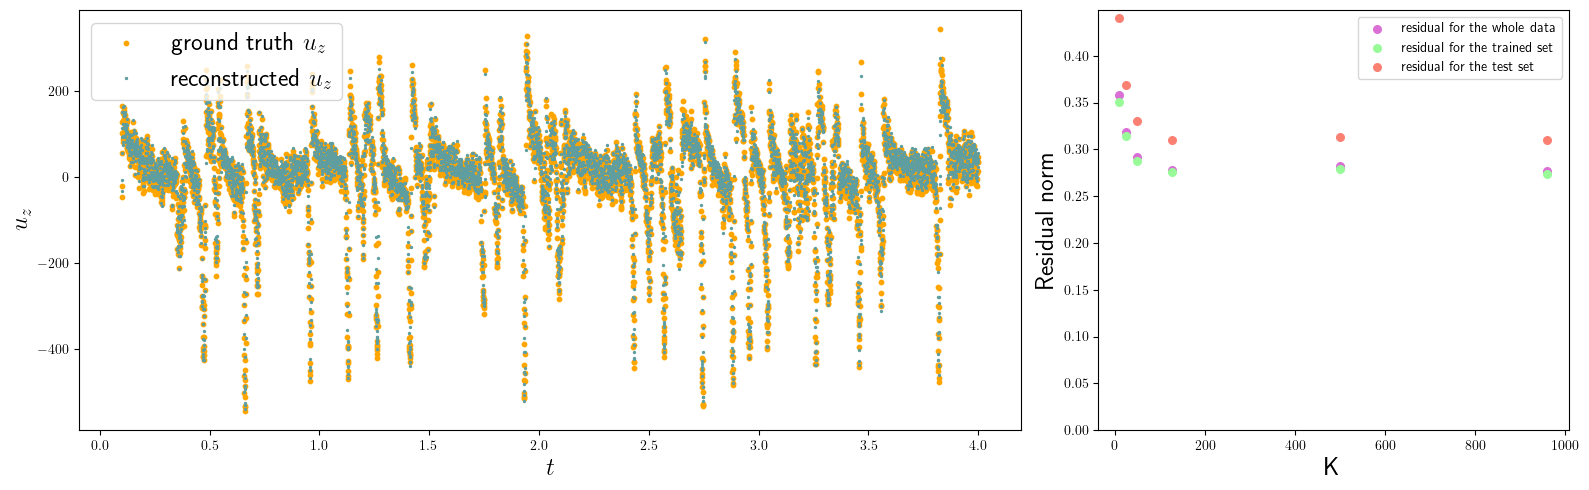

In [51]:
from utils import compute_residual_norm

Umax = simulation.Umax
Wmax = simulation.Wmax
Tmax = simulation.Tmax
uz, uzmean = simulation.UZ()

K_values = [10, 25, 50, 128, 500, 960]
t_test = int(0.9*m + 1)

residual_norm = []
residual_norm_test = []
residual_norm_train = []

for i, K in enumerate(K_values):
    decoded_data = apply_autoencoder(K)
    decoded_simulation = Simulation(current_directory, normalize = False)
    decoded_simulation.reconstruct_simulation(decoded_data.cpu().numpy(), rgb = True, normalize = [Umax, Wmax, Tmax])

    X = np.reshape(simulation.X_rgb, (m, 3*h*l))
    X_reconstructed = np.reshape(decoded_simulation.X_rgb, (m, 3*h*l))

    X_test = np.reshape(simulation.X_rgb[:, t_test:, :,:], (m - t_test, 3*h*l))
    X_reconstructed_test = np.reshape(decoded_simulation.X_rgb[:, t_test:, :,:], (m - t_test, 3*h*l))

    X_train = np.reshape(simulation.X_rgb[:, :t_test, :,:], (t_test, 3*h*l))
    X_reconstructed_train = np.reshape(decoded_simulation.X_rgb[:,:t_test, :,:], (t_test, 3*h*l))

    residual_norm.append(compute_residual_norm(X, X_reconstructed))
    residual_norm_test.append(compute_residual_norm(X_test, X_reconstructed_test))
    residual_norm_train.append(compute_residual_norm(X_train, X_reconstructed_train))

    uz_decoded, uzmean_decoded = decoded_simulation.UZ()
    plot_uz()
print(residual_norm, residual_norm_test, residual_norm_train)

normalized
Decoded simulation :


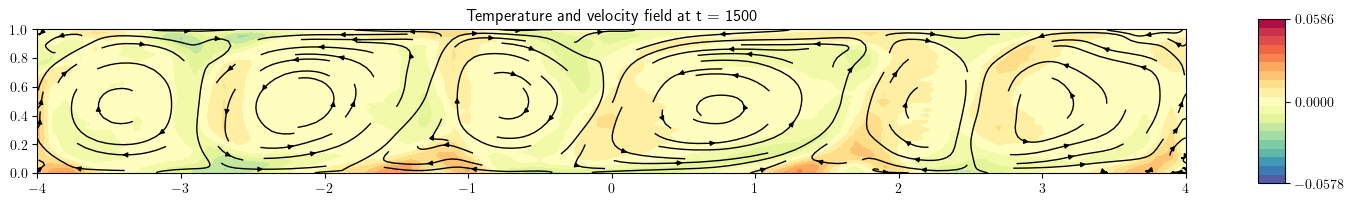

Ground Truth :


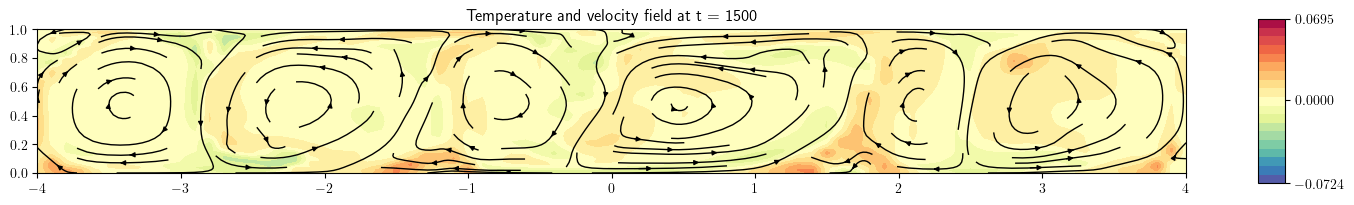

In [8]:
from data_analysis import Simulation

Umax = simulation.Umax
Wmax = simulation.Wmax
Tmax = simulation.Tmax
decoded_simulation = Simulation(current_directory, normalize = False)
decoded_simulation.reconstruct_simulation(decoded_data.cpu().numpy(), rgb = True, normalize = [Umax, Wmax, Tmax])

t = 1500
print("Decoded simulation :")
decoded_simulation.plot_field(t)
print('Ground Truth :')
simulation.plot_field(t)

In [30]:
decoded_simulation.save_clip(1550, 1650, f'{current_directory}/results/autoencoder/cnn/snapshots/')

from utils import make_gif

make_gif(f'{current_directory}/results/autoencoder/cnn/snapshots/', f'{current_directory}/results/gif/cnn_decoded_field_bs{batch_size}_test_K={K}.gif', 10)

GIF created at: ..//results/gif/cnn_decoded_field_bs4_test_K=128.gif


In [19]:
uz_decoded, uzmean_decoded = decoded_simulation.UZ()
uz, uzmean = simulation.UZ()

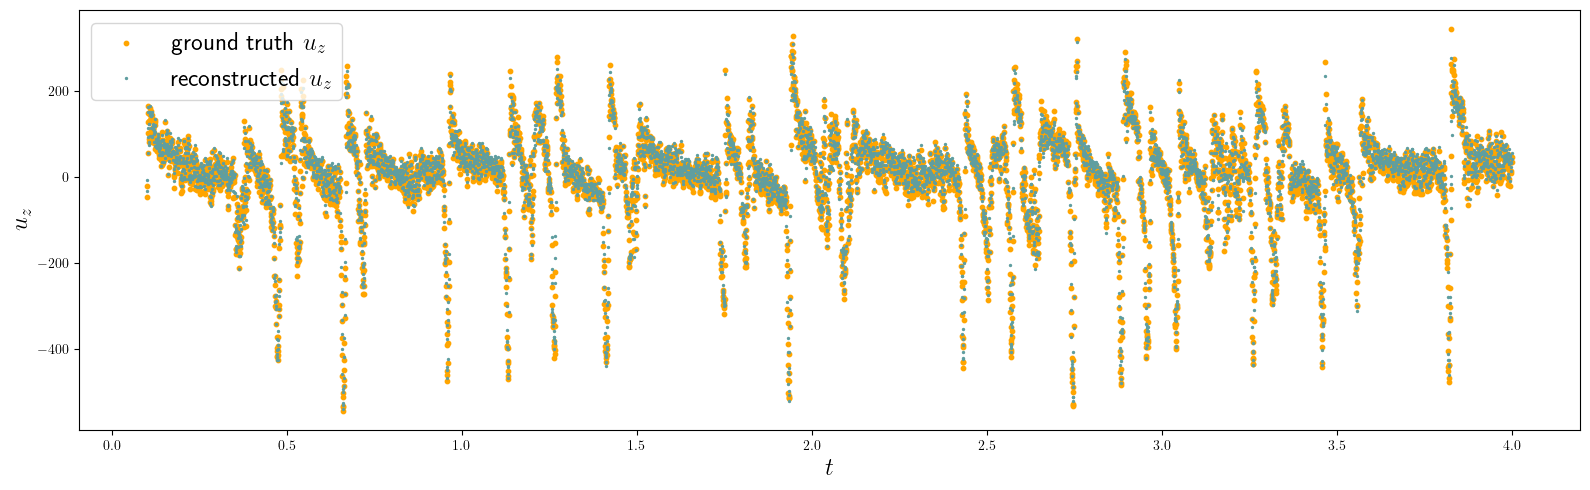

In [21]:
fig, ax1 = plt.subplots(figsize = (16, 5))


ax1.scatter(time.cpu(), uz, s = 10, c = 'orange', label = r'ground truth $u_z$')
ax1.scatter(time.cpu(), uz_decoded + uzmean, s = 2, c = 'cadetblue', label = r'reconstructed $u_z$')

ax1.set_ylabel(r'$u_z$', fontsize= fontsize)
ax1.set_xlabel(r'$t$', fontsize = fontsize)
ax1.legend(fontsize = fontsize, loc = 'upper left')

fig.tight_layout()

In [49]:
def plot_uz():
    fig, [ax1,ax2] = plt.subplots(1,2,figsize = (16, 5), gridspec_kw={'width_ratios': [2, 1]})


    ax1.scatter(time.cpu(), uz, s = 10, c = 'orange', label = r'ground truth $u_z$')
    ax1.scatter(time.cpu(), uz_decoded + uzmean, s = 2, c = 'cadetblue', label = r'reconstructed $u_z$')
    ax1.set_ylabel(r'$u_z$', fontsize= fontsize)
    ax1.set_xlabel(r'$t$', fontsize = fontsize)
    ax1.legend(fontsize = fontsize, loc = 'upper left')


    ax2.scatter(K_values[:i+1], residual_norm, s = 30, c = 'orchid', label = r"residual for the whole data")
    ax2.scatter(K_values[:i+1], residual_norm_train, s = 30, c = 'palegreen', label = r"residual for the trained set")
    ax2.scatter(K_values[:i+1], residual_norm_test, s = 30, c = 'salmon', label = r"residual for the test set")

    # ax.set_title(r"Residual norm")
    ax2.set_ylabel('Residual norm', fontsize = fontsize)
    ax2.set_xlabel('K', fontsize = fontsize)
    ax2.set_ylim(bottom = 0)
    ax2.legend()
    # fig.suptitle(f'number of modes = {num_modes} ', fontsize = fontsize)
    fig.tight_layout()

In [ ]:
plt.savefig(f'../results/POD/uz/uz_{i}.png',dpi=300)
    plt.close()

In [1]:
fig, ax2 = plt.subplots(figsize = (10, 7)) 
ax2.scatter(K_values, residual_norm, s = 30, c = 'orchid', label = r"residual for the whole data")
ax2.scatter(K_values, residual_norm_train, s = 30, c = 'palegreen', label = r"residual for the trained set")
ax2.scatter(K_values, residual_norm_test, s = 30, c = 'salmon', label = r"residual for the test set")

# ax.set_title(r"Residual norm")
ax2.set_ylabel('Residual norm', fontsize = fontsize)
ax2.set_xlabel('K', fontsize = fontsize)
ax2.set_ylim(bottom = 0)
ax2.legend()
# fig.suptitle(f'number of modes = {num_modes} ', fontsize = fontsize)
fig.tight_layout()

NameError: name 'plt' is not defined